In [1]:
!pip install transformers datasets torchvision torch numpy


In [3]:
import shutil
import os

# Create the Kaggle directory and move kaggle.json there
os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
shutil.move('kaggle.json', os.path.expanduser('~/.kaggle/kaggle.json'))

'/root/.kaggle/kaggle.json'

In [4]:
!kaggle datasets download -d arjuntejaswi/plant-village


Dataset URL: https://www.kaggle.com/datasets/arjuntejaswi/plant-village
License(s): unknown
plant-village.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
import zipfile
import os
import shutil

# Unzip the dataset
with zipfile.ZipFile("plant-village.zip", 'r') as zip_ref:
    zip_ref.extractall("plant_village")

# Define the path to remove
path_to_remove = "plant_village/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/svn-r6Yb5c"

# Remove the file or directory
if os.path.exists(path_to_remove):
    if os.path.isdir(path_to_remove):
        shutil.rmtree(path_to_remove)
        print(f"Directory {path_to_remove} has been removed.")
    else:
        os.remove(path_to_remove)
        print(f"File {path_to_remove} has been removed.")
else:
    print(f"Path {path_to_remove} does not exist.")


File plant_village/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/svn-r6Yb5c has been removed.


In [6]:
from sklearn.model_selection import train_test_split
from datasets import load_dataset
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from transformers import AutoFeatureExtractor, AutoModelForImageClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score
import os
from PIL import Image

# Define a custom dataset class
class PlantVillageDataset(Dataset):
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Specify the data directory and gather all image paths and labels
data_dir = "plant_village/PlantVillage"
classes = sorted(os.listdir(data_dir))
img_paths = []
labels = []

for idx, cls in enumerate(classes):
    cls_dir = os.path.join(data_dir, cls)
    for img_file in os.listdir(cls_dir):
        img_paths.append(os.path.join(cls_dir, img_file))
        labels.append(idx)

# Split the dataset into train, validation, and test sets
train_paths, test_paths, train_labels, test_labels = train_test_split(img_paths, labels, test_size=0.2, stratify=labels)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=0.25, stratify=train_labels)

# Define the transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create dataset objects
train_dataset = PlantVillageDataset(train_paths, train_labels, transform=transform)
val_dataset = PlantVillageDataset(val_paths, val_labels, transform=transform)
test_dataset = PlantVillageDataset(test_paths, test_labels, transform=transform)


In [7]:
from transformers import ViTImageProcessor, ViTForImageClassification

model_name = "google/vit-base-patch16-224-in21k"
feature_extractor = ViTImageProcessor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(model_name, num_labels=len(classes))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [9]:
!pip install transformers[torch] -U
!pip install accelerate -U


In [10]:
# Step 8: Define Training Arguments and Trainer
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",  # Update here
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

# Define a custom collator to handle image inputs
class DataCollatorForImageClassification(DataCollatorWithPadding):
    def __call__(self, features):
        pixel_values = torch.stack([feature[0] for feature in features])
        labels = torch.tensor([feature[1] for feature in features])
        return {"pixel_values": pixel_values, "labels": labels}

data_collator = DataCollatorForImageClassification(feature_extractor)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()




/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch,Training Loss,Validation Loss,Accuracy
1,1.224400,0.334484,0.979893
2,0.175100,0.139048,0.991764
3,0.110000,0.108717,0.993944


TrainOutput(global_step=2322, training_loss=0.41365261965019756, metrics={'train_runtime': 1531.9235, 'train_samples_per_second': 24.248, 'train_steps_per_second': 1.516, 'total_flos': 2.878852836361679e+18, 'train_loss': 0.41365261965019756, 'epoch': 3.0})

In [11]:
# Step 9: Evaluate the Model
metrics = trainer.evaluate(eval_dataset=test_dataset)
print(metrics)

{'eval_loss': 0.11501516401767731, 'eval_accuracy': 0.9917635658914729, 'eval_runtime': 50.5588, 'eval_samples_per_second': 81.647, 'eval_steps_per_second': 5.103, 'epoch': 3.0}


In [15]:
if True:
    torch.save(model.state_dict(), 'plant_disease_vit.pth')
    print("Model saved to plant_disease_vit.pth")

Model saved to plant_disease_vit.pth


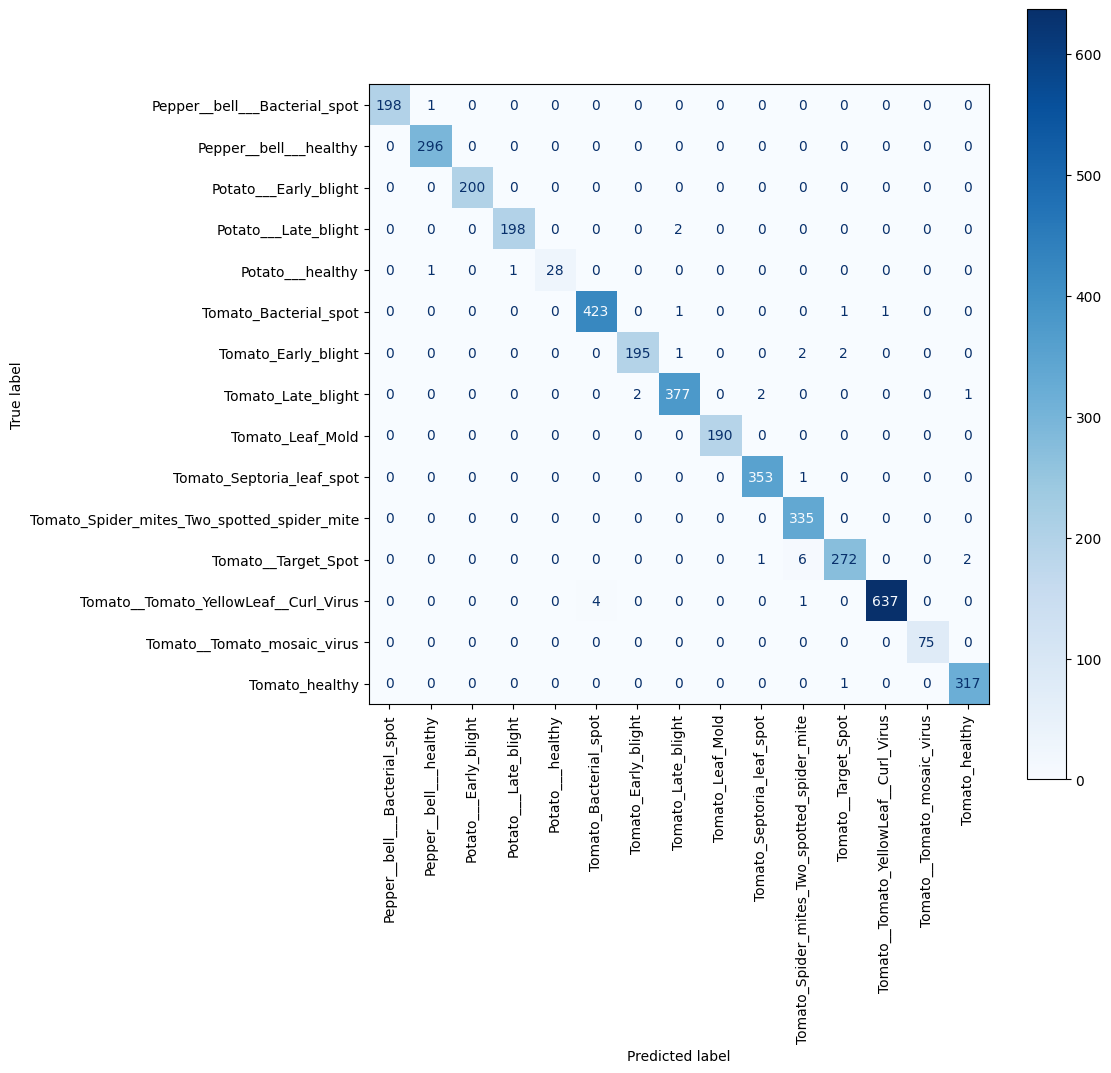

In [14]:
# Step 10: Compute and plot the confusion matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(predictions, labels, classes):
    cm = confusion_matrix(labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.xticks(rotation=90)
    plt.show()

# Get the predictions and labels for the test set
predictions = trainer.predict(test_dataset)
pred_labels = predictions.predictions.argmax(-1)
true_labels = predictions.label_ids

# Plot the confusion matrix
plot_confusion_matrix(pred_labels, true_labels, classes)


In [16]:
# Convert the model to ONNX format
import torch.onnx

In [17]:
# Load the trained model
model.load_state_dict(torch.load('plant_disease_vit.pth'))

<All keys matched successfully>

In [18]:
# Set the model to evaluation mode
model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [19]:
# Define a dummy input tensor with the same shape as the model's input
dummy_input = torch.randn(1, 3, 224, 224, device='cuda')

In [22]:
!pip install onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 45.2 MB/s eta 0:00:00


In [23]:
# Convert the model to ONNX format
import torch.onnx

# Load the trained model
model.load_state_dict(torch.load('plant_disease_vit.pth'))

# Set the model to evaluation mode
model.eval()

# Define a dummy input tensor with the same shape as the model's input
dummy_input = torch.randn(1, 3, 224, 224, device='cuda' if torch.cuda.is_available() else 'cpu')

# Export the model to ONNX
onnx_model_path = 'plant_disease_vit.onnx'
torch.onnx.export(
    model,
    dummy_input,
    onnx_model_path,
    input_names=['input'],
    output_names=['output'],
    opset_version=14,  # Updated to use opset version 14
    do_constant_folding=True,
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
)

print(f"Model has been converted to ONNX format and saved to {onnx_model_path}")


/usr/local/lib/python3.10/dist-packages/transformers/models/vit/modeling_vit.py:164: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if num_channels != self.num_channels:
/usr/local/lib/python3.10/dist-packages/transformers/models/vit/modeling_vit.py:170: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if height != self.image_size[0] or width != self.image_size[1]:


Model has been converted to ONNX format and saved to plant_disease_vit.onnx


In [25]:
!pip install onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.6 MB/s eta 0:00:00


In [34]:
import onnxruntime
import numpy as np
from PIL import Image
from torchvision import transforms

# Load the ONNX model
onnx_model_path = 'plant_disease_vit.onnx'
ort_session = onnxruntime.InferenceSession(onnx_model_path)

# Define input preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load and preprocess the input image
image_path = '/content/Alternarioza-ziemniaka.-Wykruszanie-się-tkanki-wewnątrz-nekrozy-fot.-J.-Osowski3.jpg'  # Update with your image path
image = Image.open(image_path).convert("RGB")
image = transform(image)
image = image.numpy()
image = np.expand_dims(image, axis=0)  # Add batch dimension

# Perform inference
input_name = ort_session.get_inputs()[0].name
outputs = ort_session.run(None, {input_name: image})

# Process the outputs
probabilities = outputs[0]
predicted_class_index = np.argmax(probabilities)
predicted_class = classes[predicted_class_index]  # Assuming you have classes defined

print("Predicted class:", predicted_class)
print("Probabilities:", probabilities)


Predicted class: Potato___Early_blight
Probabilities: [[ 1.5248988  -0.4057278   1.8602607   1.0812584  -0.62771356 -0.6658646
   0.8835336   0.32716167 -0.7451825  -0.29906043 -1.1169617  -0.5059797
  -0.22043788 -0.55925405 -0.6842972 ]]
